In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyEDM
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.fft import fft, ifft, fftfreq
from numpy.fft import fft, ifft

## Make Test Data

In [2]:
def make_independent_series(n=500, seed=None):
    """Pure white noise, no relationship."""
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(n)
    Y = np.random.randn(n)
    return X, Y

def make_correlated_series(n=500, rho=0.8, seed=None):
    '''Generate correlated series.'''
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(n)
    noise = np.random.randn(n)
    Y = rho*X + np.sqrt(1 - rho**2)*noise
    return X, Y

def make_correlated_autocorrelated_series(n=500, rho_cross=0.8, rho_auto=0.7, seed=None):
    """
    Generate X and Y that are:
    - Cross-correlated (corr(X, Y) ≈ rho_cross)
    - Y is autocorrelated (AR(1) with coefficient rho_auto)
    - X has no autocorrelation
    
    Args:
        n: Number of time points
        rho_cross: Cross-correlation between X and Y
        rho_auto: Autocorrelation in Y (AR(1) coefficient)
        seed: Random seed
    """
    if seed is not None:
        np.random.seed(seed)
    # X is white noise (no autocorrelation)
    X = np.random.randn(n)
    # Y is AR(1) process influenced by X
    Y = np.zeros(n)
    Y[0] = np.random.randn()
    for t in range(1, n):
        # Y(t) depends on:
        # 1. Its own past (autocorrelation)
        # 2. Current X value (cross-correlation)
        # 3. Independent noise
        # Compute weights to achieve desired correlations
        # This is approximate - may need tuning
        Y[t] = (rho_auto * Y[t-1] + 
                rho_cross * X[t] + 
                np.sqrt(1 - rho_auto**2 - rho_cross**2) * np.random.randn())
    return X, Y

def make_pure_autocorrelated_series(n=500, rho_auto=0.7, seed=None):
    """
    Y is autocorrelated, X is independent white noise
    No relationship between X and Y at all
    """
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(n)  # Independent
    Y = np.zeros(n)
    Y[0] = np.random.randn()
    for t in range(1, n):
        Y[t] = rho_auto * Y[t-1] + np.sqrt(1 - rho_auto**2) * np.random.randn()
    return X, Y

def make_seasonal_series(n=500, period=24, phase_diff=0, seed=None):
    """
    Both X and Y driven by same seasonal signal
    phase_diff: phase difference in radians (0 = synchronous)
    """
    if seed is not None:
        np.random.seed(seed)
    t = np.arange(n)
    seasonal = np.sin(2 * np.pi * t / period)
    X = seasonal + 0.3 * np.random.randn(n)
    Y = np.sin(2 * np.pi * t / period + phase_diff) + 0.3 * np.random.randn(n)
    return X, Y

def make_causal_series(n=500, coupling=0.2, noise=0.01, seed=None,rX=3.7, rY=3.6):
    """
    X -> Y via multiplicative (parameter) coupling.
    rY_eff = rY * (1 + coupling * (X[t-1]-0.5))
    """
    if seed is not None:
        np.random.seed(seed)
    X = np.zeros(n); Y = np.zeros(n)
    X[0], Y[0] = np.random.rand(), np.random.rand()

    for t in range(1, n):
        X[t] = rX * X[t-1] * (1 - X[t-1]) + noise * np.random.randn()
        rY_eff = rY * (1 + coupling * (X[t-1] - 0.5))
        Y[t] = rY_eff * Y[t-1] * (1 - Y[t-1]) + noise * np.random.randn()

        # tiny numeric safety bounds (not hard clipping)
        X[t] = np.clip(X[t], 1e-12, 1-1e-12)
        Y[t] = np.clip(Y[t], 1e-12, 1-1e-12)

    return X, Y

def make_bidirectional_causal_series(n=500, coupling_XY=0.4, coupling_YX=0.4, noise=0.05, seed=None,rX=3.7, rY=3.6):
    """
    Bidirectional causal system:
        X → Y with strength coupling_XY
        Y → X with strength coupling_YX
    Uses multiplicative parameter coupling so the system stays bounded
    and remains chaotic without hard clipping.
    """
    if seed is not None:
        np.random.seed(seed)
    X = np.zeros(n)
    Y = np.zeros(n)
    # random initial conditions
    X[0] = np.random.rand()
    Y[0] = np.random.rand()
    for t in range(1, n):
        # logistic base
        Fx = rX * X[t-1] * (1 - X[t-1])
        Fy = rY * Y[t-1] * (1 - Y[t-1])
        # multiplicative parameter coupling:
        #   the driver modulates the effective growth rate
        rX_eff = rX * (1 + coupling_YX * (Y[t-1] - 0.5))
        rY_eff = rY * (1 + coupling_XY * (X[t-1] - 0.5))
        # update with effective parameters
        X[t] = rX_eff * X[t-1] * (1 - X[t-1]) + noise * np.random.randn()
        Y[t] = rY_eff * Y[t-1] * (1 - Y[t-1]) + noise * np.random.randn()
        # keep values inside the logistic basin without hard clipping
        X[t] = np.clip(X[t], 1e-6, 1 - 1e-6)
        Y[t] = np.clip(Y[t], 1e-6, 1 - 1e-6)
    return X, Y

def make_indirect_causal_series(n=500, coupling_XZ=0.2, coupling_ZY=0.2, noise=0.02, seed=None, rX=3.7, rZ=3.8, rY=3.6):
    """
    Indirect causal chain: X -> Z -> Y using multiplicative (parameter) coupling.
    Values remain in (0,1) (soft clipped numerically) and dynamics stay rich.
    """
    if seed is not None:
        np.random.seed(seed)
    X = np.zeros(n)
    Z = np.zeros(n)
    Y = np.zeros(n)
    X[0], Z[0], Y[0] = np.random.rand(), np.random.rand(), np.random.rand()
    for t in range(1, n):
        # autonomous X (logistic)
        X[t] = rX * X[t-1] * (1 - X[t-1]) + noise * np.random.randn()
        # effective r for Z is modulated by X[t-1]
        rZ_eff = rZ * (1 + coupling_XZ * (X[t-1] - 0.5))
        Z[t] = rZ_eff * Z[t-1] * (1 - Z[t-1]) + noise * np.random.randn()
        # effective r for Y is modulated by Z[t-1]  (no direct X->Y)
        rY_eff = rY * (1 + coupling_ZY * (Z[t-1] - 0.5))
        Y[t] = rY_eff * Y[t-1] * (1 - Y[t-1]) + noise * np.random.randn()
        # tiny numerical safety clamp (not hard clipping)
        X[t] = np.clip(X[t], 1e-12, 1 - 1e-12)
        Z[t] = np.clip(Z[t], 1e-12, 1 - 1e-12)
        Y[t] = np.clip(Y[t], 1e-12, 1 - 1e-12)
    return X, Z, Y

In [3]:
# Independent
X_indep, Y_indep = make_independent_series(n=500, seed=1)

# Correlated (non-causal)
X_corr, Y_corr = make_correlated_series(n=500, rho=0.8, seed=1)

# Lag-correlated (non-causal)
X_lagcorr = X_corr.copy()
Y_lagcorr = shift(Y_corr, shift=3, cval=np.nan)

# Correlated AND autocorrelated (non-causal)
X_auto, Y_auto = make_correlated_autocorrelated_series(n=500, rho_cross=0.7, rho_auto=0.6, seed=1)

# Pure autocorrelated
X_pure_auto, Y_pure_auto = make_pure_autocorrelated_series(n=500, rho_auto=0.8, seed=1)

# Seasonal synchronous
X_seasonal_sync, Y_seasonal_sync = make_seasonal_series(n=500, period=24, phase_diff=0, seed=1)

# Seasonal lagged
X_seasonal_lag, Y_seasonal_lag = make_seasonal_series(n=500, period=24, phase_diff=np.pi/6, seed=1)

# Unidirectional causal
X_causal, Y_causal = make_causal_series(n=500, coupling=0.6, noise=0.05, seed=1)

# Bidirectional causal
X_bidir, Y_bidir = make_bidirectional_causal_series(n=500, coupling_XY=0.4, coupling_YX=0.4, noise=0.05, seed=1)

# Weak causal
X_weak, Y_weak = make_causal_series(n=500, coupling=0.2, noise=0.05, seed=1)

# Indirect causal
#X_indirect, Z_indirect, Y_indirect = make_indirect_causal_series(n=500, coupling=0.5, noise=0.05, seed=1)
X_indirect, Z_indirect, Y_indirect = make_indirect_causal_series(n=500,coupling_XZ=0.18,coupling_ZY=0.18,noise=0.02,seed=1)

test_cases = [
    # Non-causal cases (should all be rejected)
    ("Independent", X_indep, Y_indep, False),
    ("Correlated", X_corr, Y_corr, False),
    ("Lag-correlated", X_lagcorr, Y_lagcorr, False),
    ("Correlated & Autocorrelated", X_auto, Y_auto, False),
    ("Pure autocorrelated", X_pure_auto, Y_pure_auto, False),
    ("Seasonal synchronous", X_seasonal_sync, Y_seasonal_sync, False),
    ("Seasonal lagged", X_seasonal_lag, Y_seasonal_lag, False),
    
    # Causal cases (should be detected)
    ("Unidirectional causal", X_causal, Y_causal, True),
    ("Bidirectional causal", X_bidir, Y_bidir, True),
    ("Weak causal", X_weak, Y_weak, "uncertain"),
    ("Indirect causal", X_indirect, Y_indirect, "uncertain"),
]

## Functions to Make Surrogates

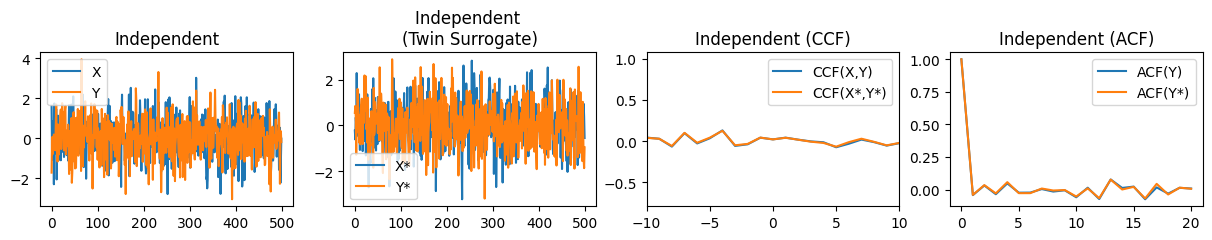

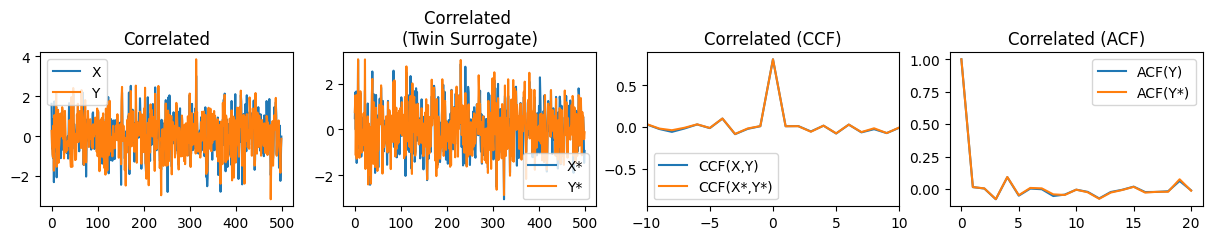

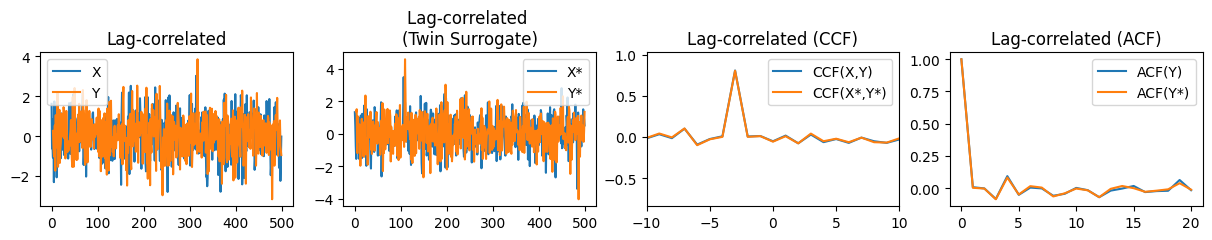

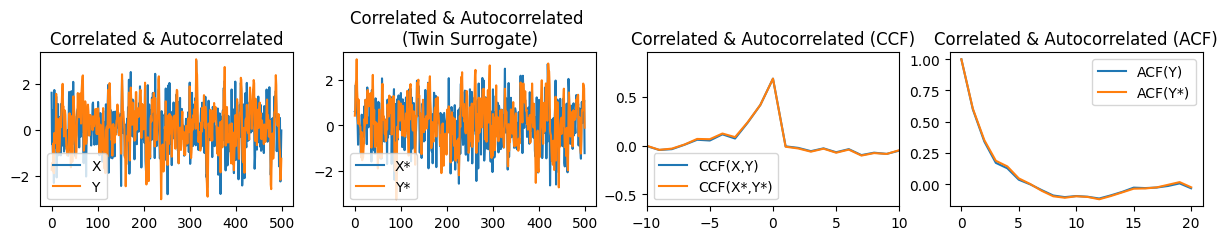

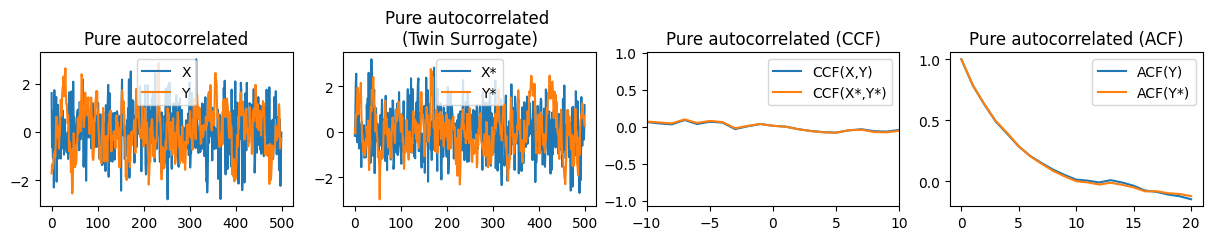

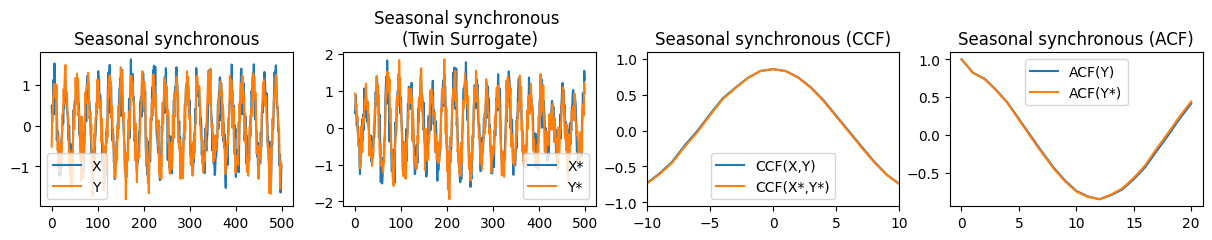

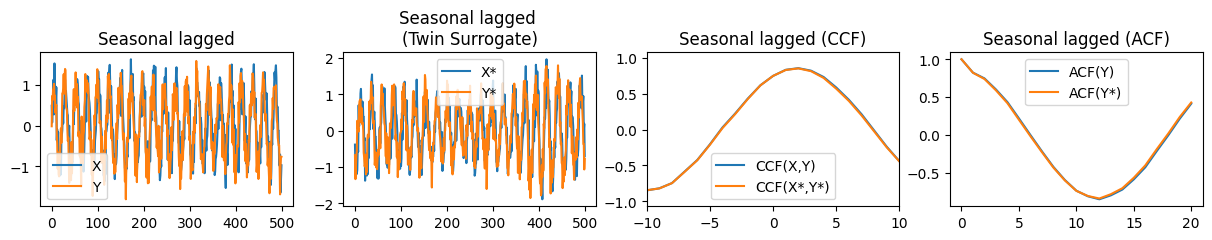

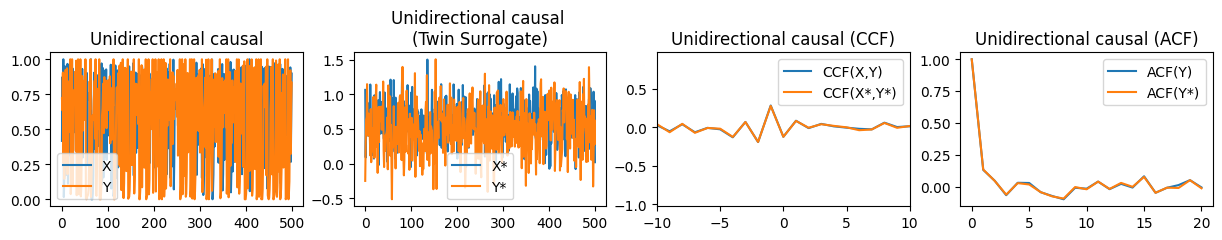

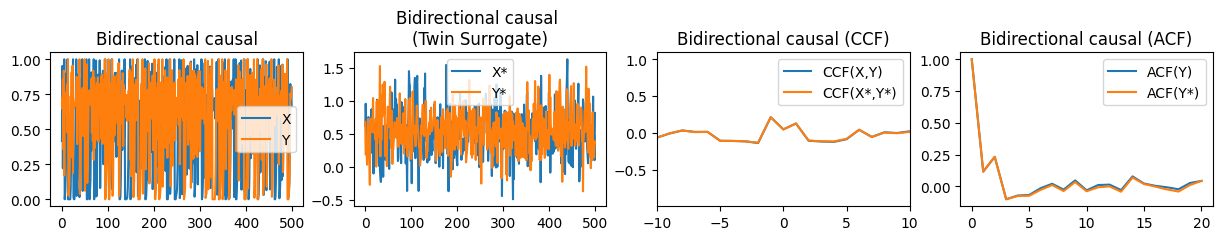

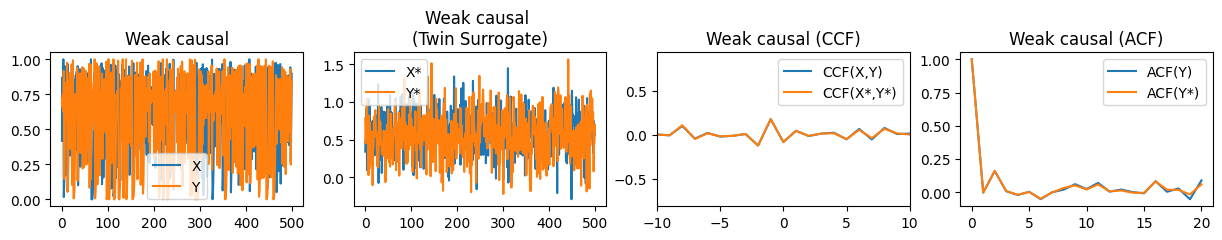

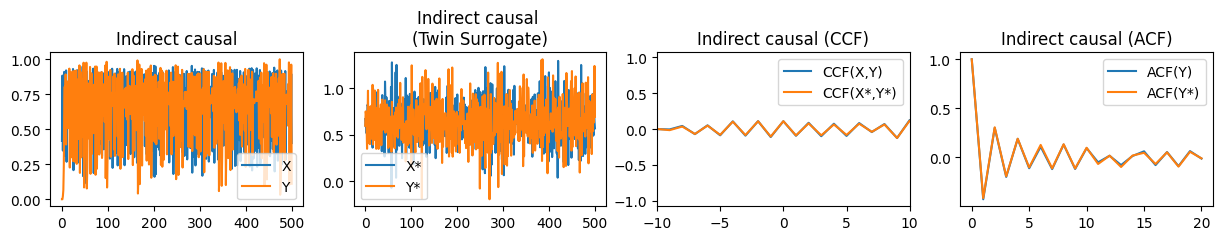

In [4]:
def twin_surrogates(X, Y):
    """
    Generate twin surrogates of X and Y that:
      - preserve their individual power spectra,
      - preserve the cross-spectrum (shared phase structure),
      - destroy temporal ordering,
      - AND keep NaNs in exactly the same locations.
    Parameters
    X, Y : 1D arrays with NaNs allowed
    Returns
    X_surr, Y_surr : surrogate arrays with NaNs in original positions
    """
    # 1. Record NaN positions
    nan_mask_X = np.isnan(X)
    nan_mask_Y = np.isnan(Y)

    # 2. Replace NaNs with 0
    # FFT *cannot* handle NaNs, but zeros do NOT affect the spectrum because we reapply the mask afterward.
    X_clean = np.where(nan_mask_X, 0.0, X)
    Y_clean = np.where(nan_mask_Y, 0.0, Y)

    n = len(X_clean)

    # 3. FFT of both series
    X_fft = fft(X_clean)
    Y_fft = fft(Y_clean)

    # 4. Generate symmetric random phase sequence
    n_freqs = n // 2 + 1
    random_phases = np.random.uniform(-np.pi, np.pi, n_freqs)

    # DC (0 freq) must stay real
    random_phases[0] = 0

    # Nyquist freq (for even n) must stay real
    if n % 2 == 0:
        random_phases[-1] = 0

    # Build full symmetric phase vector for real IFFT
    if n % 2 == 0:
        full_phases = np.concatenate([random_phases,
                                      -random_phases[-2:0:-1]])
    else:
        full_phases = np.concatenate([random_phases,
                                      -random_phases[-1:0:-1]])

    # 5. Apply the SAME random phase shift to X and Y (preserves cross-spectrum)
    X_fft_surr = np.abs(X_fft) * np.exp(1j * (np.angle(X_fft) + full_phases))
    Y_fft_surr = np.abs(Y_fft) * np.exp(1j * (np.angle(Y_fft) + full_phases))

    # 6. Inverse FFT
    X_surr = np.real(ifft(X_fft_surr))
    Y_surr = np.real(ifft(Y_fft_surr))

    # 7. Restore NaN positions
    X_surr[nan_mask_X] = np.nan
    Y_surr[nan_mask_Y] = np.nan

    return X_surr, Y_surr

def cross_correlation(x, y):
    """
    Compute Pearson cross-correlation at each lag (bounded [-1, 1]),
    using pairwise-complete observations and handling NaNs correctly.
    """

    x = np.asarray(x, float)
    y = np.asarray(y, float)
    n = len(x)

    # subtract global means (using available data)
    x0 = x - np.nanmean(x)
    y0 = y - np.nanmean(y)

    lags = np.arange(-n + 1, n)
    corr = np.zeros(len(lags))

    for i, lag in enumerate(lags):
        if lag < 0:
            xs = x0[:lag]         # x[0 : n+lag]
            ys = y0[-lag:]        # y[-lag : n]
        else:
            xs = x0[lag:]         # x[lag : n]
            ys = y0[:n - lag]     # y[0 : n-lag]

        # pairwise valid values
        mask = (~np.isnan(xs)) & (~np.isnan(ys))

        if mask.sum() < 2:
            corr[i] = np.nan
            continue

        xs_valid = xs[mask]
        ys_valid = ys[mask]

        # numerator
        num = np.sum(xs_valid * ys_valid)

        # denominator for Pearson correlation
        denom = np.sqrt(np.sum(xs_valid**2) * np.sum(ys_valid**2))

        if denom == 0:
            corr[i] = np.nan
        else:
            corr[i] = num / denom

    return lags, corr

def acf_nan(y, nlags=20):
    """
    Compute autocorrelation with NaN handling.
    Uses pairwise-complete observations for each lag.
    Parameters:
        y : 1D array with possible NaNs
        nlags : maximum lag to compute 
    Returns:
        acf : array of length nlags+1
    """
    y = np.asarray(y, float)
    n = len(y)
    acf_vals = []
    # centered series (but mean must be computed on non-NaN)
    y_mean = np.nanmean(y)
    y_centered = y - y_mean
    # denominator: variance using non-NaN values
    denom = np.nansum(y_centered ** 2)
    for lag in range(nlags + 1):
        # indices that are valid for this lag
        valid = (~np.isnan(y_centered[:n-lag])) & (~np.isnan(y_centered[lag:]))
        if not np.any(valid):
            acf_vals.append(np.nan)
        else:
            num = np.sum(y_centered[:n-lag][valid] * y_centered[lag:][valid])
            acf_vals.append(num / denom)
    return np.array(acf_vals)

for case in test_cases:
    name = case[0]
    X_test = case[1]
    Y_test = case[2]
    lags, corr = cross_correlation(X_test, Y_test)
    acf_test = acf_nan(Y_test)

    X_surr, Y_surr = twin_surrogates(X_test,Y_test)
    lags_surr, corr_surr = cross_correlation(X_surr, Y_surr)
    acf_surr = acf_nan(Y_surr)

    fig, ax = plt.subplots(1,4,figsize=(15,2))
    ax[0].plot(X_test, label='X')
    ax[0].plot(Y_test, label='Y')
    ax[0].set_title(name)
    ax[0].legend()

    ax[1].plot(X_surr, label='X*')
    ax[1].plot(Y_surr, label='Y*')
    ax[1].set_title(f'{name} \n(Twin Surrogate)')
    ax[1].legend()

    ax[2].plot(lags, corr, label='CCF(X,Y)')
    ax[2].plot(lags_surr, corr_surr, label='CCF(X*,Y*)')
    ax[2].set_title(f'{name} (CCF)')
    ax[2].set_xlim(-10,10)
    ax[2].legend()

    ax[3].plot(acf_test, label='ACF(Y)')
    ax[3].plot(acf_surr, label='ACF(Y*)')
    ax[3].set_title(f'{name} (ACF)')
    ax[3].legend()
    
    plt.show()

## Functions for CCM Analysis

In [5]:
def compute_xmap_pair(dataFrame, columns, target, lib, pred, E, Tp, tau, exclusionRadius, noTime=False):
    """Compute the cross-mapping from columns to target."""

    # Set up validLib for NaN handling
    to_xmap = dataFrame.copy()
    to_xmap['validLib'] = to_xmap[target].shift(-Tp).notna()

    result = pyEDM.Simplex(dataFrame=to_xmap, columns=columns, target=target, lib=lib, pred=pred, E=E, Tp=Tp, tau=tau,
                           exclusionRadius=exclusionRadius, validLib=to_xmap['validLib'])
    return result

def compute_ccm_pair(dataFrame, columns, target, libSizes, sample, E, Tp, tau, exclusionRadius, noTime=False):
    """Compute CCM for a variable pair (test if target causes columns)."""
    
    # Parse libSizes string (format: "start end increment")
    lib_params = libSizes.split()
    start_lib = int(lib_params[0])
    end_lib = int(lib_params[1])
    increment = int(lib_params[2])
    
    lib_sizes = list(range(start_lib, end_lib + 1, increment))
    
    # Generate random libraries
    results = []

    for libSize in lib_sizes:
        for i in range(sample):
            # Generate random library indices
            max_index = len(dataFrame)

            # Randomly sample an end index
            end_idx = np.random.randint(libSize, max_index + 1)
            start_idx = end_idx - libSize
            
            # Create lib string in pyEDM format (1-based indexing)
            lib = f"{start_idx + 1} {end_idx}"
            pred = lib  # Use same range for prediction

            # Get cross-map results
            try:
                xmap = compute_xmap_pair(dataFrame, columns, target, lib, pred, E, Tp, tau, exclusionRadius)
                rho = xmap[['Observations', 'Predictions']].corr().iloc[0,1]
            except Exception as e:
                #print(f'compute_ccm_pair(): CCM failed with error {e}')
                xmap = None
                rho = None

            results.append({
                'LibSize': libSize,
                'lib': lib,
                'pred': pred,
                'rho': rho,
                'xmap': xmap
            })

    # Create summary table
    ccm_results = pd.DataFrame(results)
    
    summary = (
    ccm_results
    .groupby('LibSize')['rho']
    .agg(rho_mean=lambda x: x.mean(skipna=True),
         rho_std=lambda x: x.std(skipna=True, ddof=0))
    .reset_index()
    )
    
    return summary, ccm_results



----------------------------------------------------------------------
testing Independent
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 1 where ACF ≈ -0.041
Step 2: Found E = 2 with ρ = 0.036
         Max ρ = 0.036, threshold = 0.001 (1σ below max)
Step 3: Found Tp = -1 with ρ = 0.076
         Max ρ = 0.081, threshold = 0.018 (1σ below max)


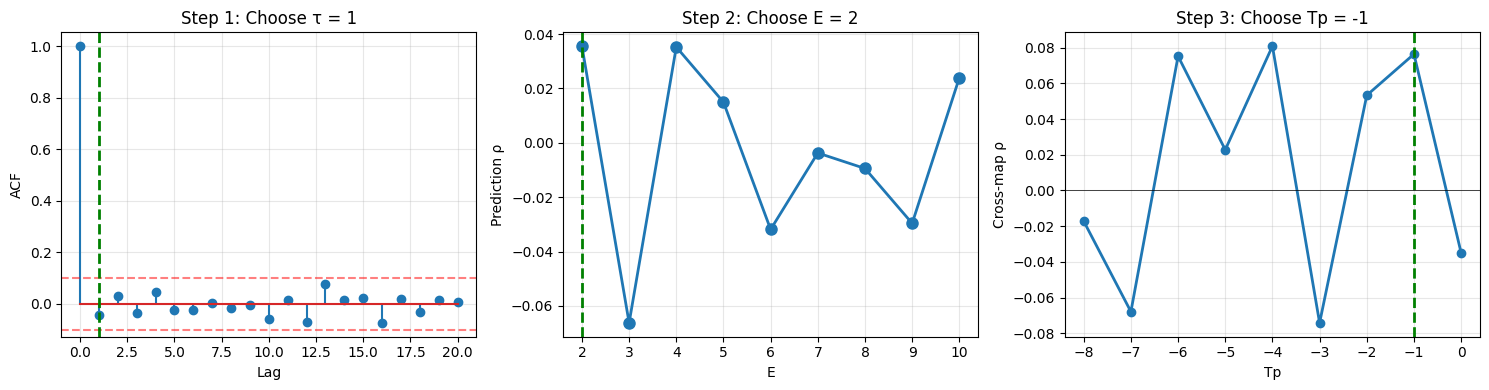


TESTING WITH SURROGATES (τ=1, E=2, Tp=-1)
Computing original CCM...
Original AUC: 1.16

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:19<00:00,  5.01it/s]



Results:
  Original AUC: 1.16
  Surrogate AUC: -3.10 ± 21.71
  Effect size: 4.26
  p-value: 0.3800
  Significant: False


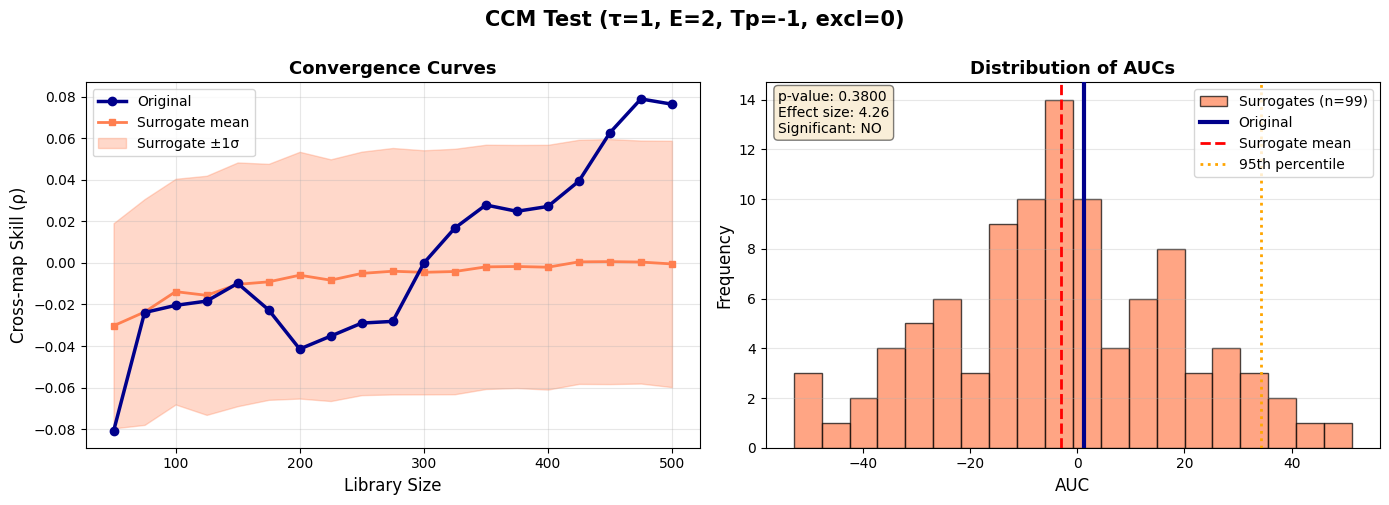

----------------------------------------------------------------------
testing Correlated
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 1 where ACF ≈ 0.014
Step 2: Found E = 5 with ρ = 0.046
         Max ρ = 0.046, threshold = 0.020 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.708
         Max ρ = 0.734, threshold = 0.433 (1σ below max)


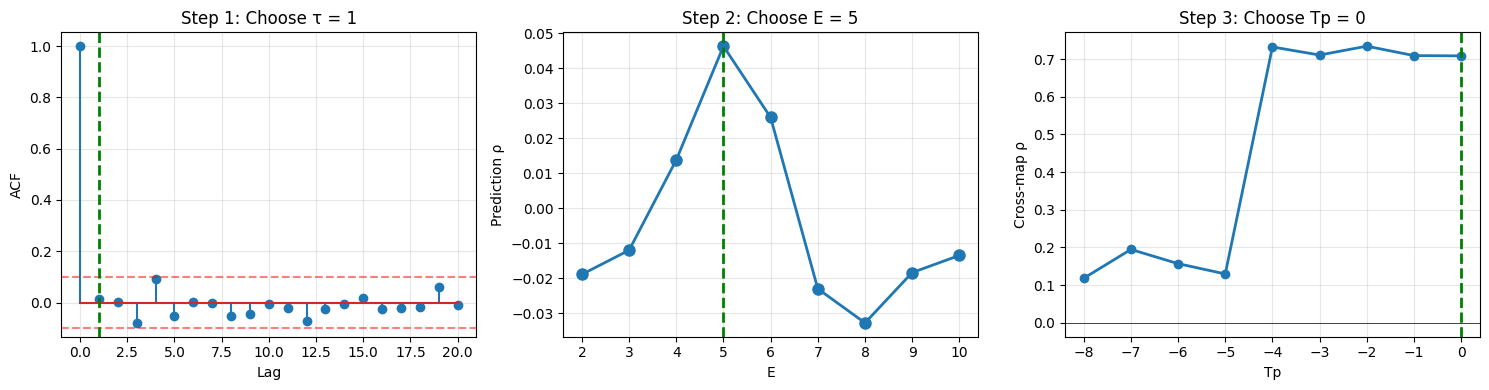


TESTING WITH SURROGATES (τ=1, E=5, Tp=0)
Computing original CCM...
Original AUC: 312.61

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:21<00:00,  4.69it/s]



Results:
  Original AUC: 312.61
  Surrogate AUC: 319.92 ± 6.22
  Effect size: -7.31
  p-value: 0.8900
  Significant: False


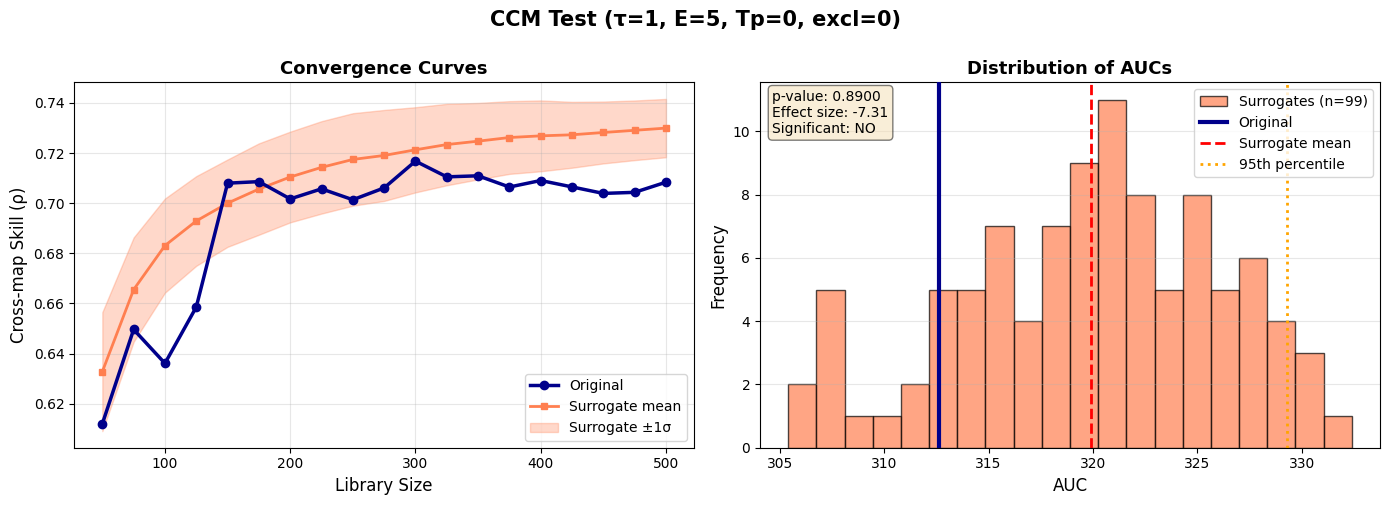

----------------------------------------------------------------------
testing Lag-correlated
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 1 where ACF ≈ 0.008
Step 2: Found E = 5 with ρ = 0.063
         Max ρ = 0.063, threshold = 0.031 (1σ below max)
Step 3: Found Tp = -3 with ρ = 0.704
         Max ρ = 0.711, threshold = 0.400 (1σ below max)


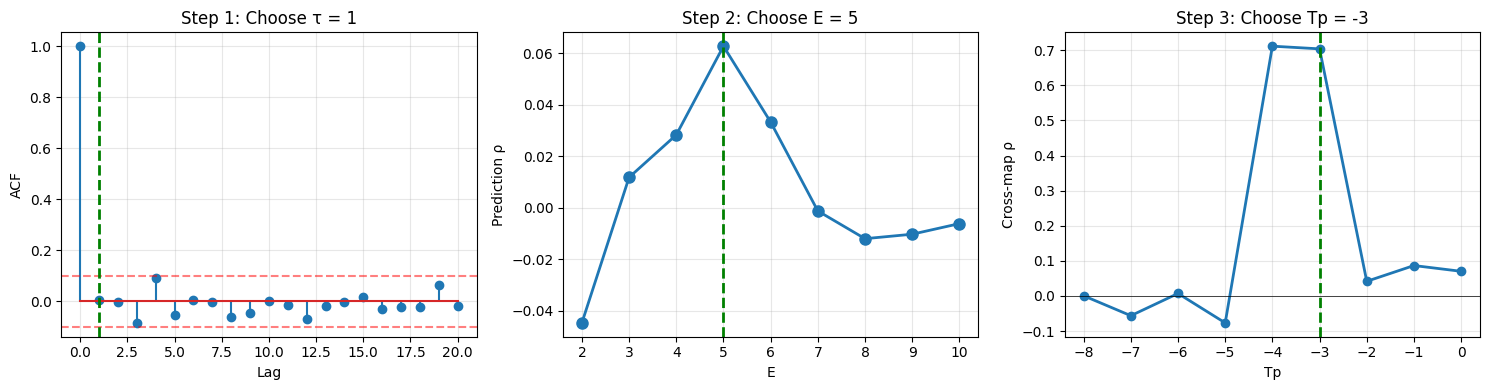


TESTING WITH SURROGATES (τ=1, E=5, Tp=-3)
Computing original CCM...
Original AUC: 312.02

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:20<00:00,  4.84it/s]



Results:
  Original AUC: 312.02
  Surrogate AUC: 315.89 ± 6.54
  Effect size: -3.88
  p-value: 0.7200
  Significant: False


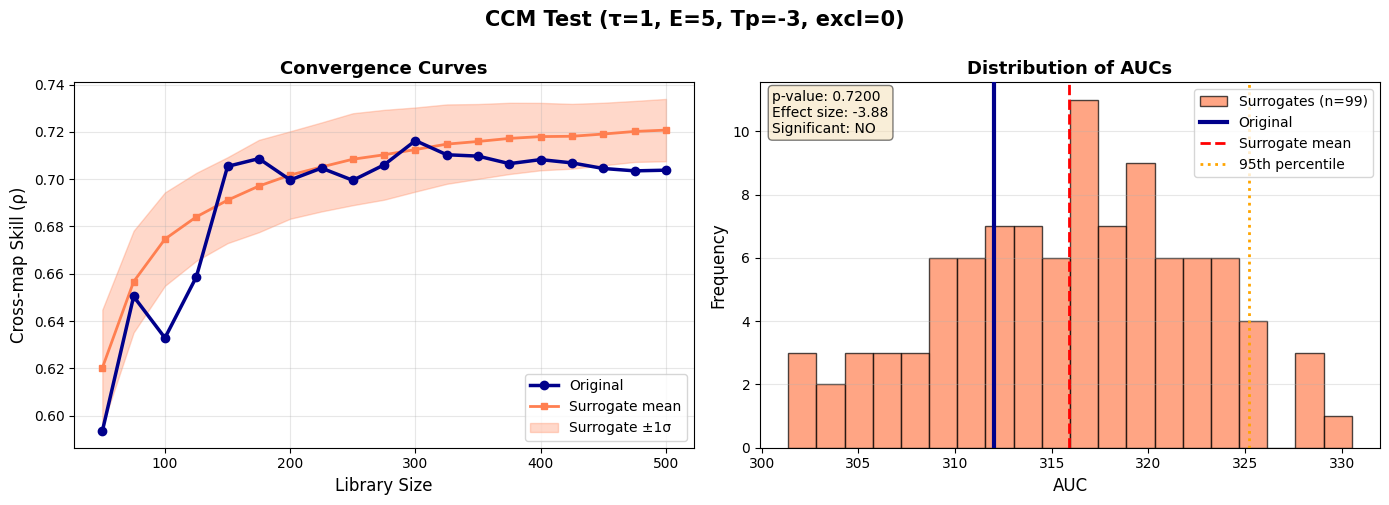

----------------------------------------------------------------------
testing Correlated & Autocorrelated
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 5 where ACF ≈ 0.036
Step 2: Found E = 4 with ρ = 0.479
         Max ρ = 0.479, threshold = 0.452 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.571
         Max ρ = 0.573, threshold = 0.349 (1σ below max)


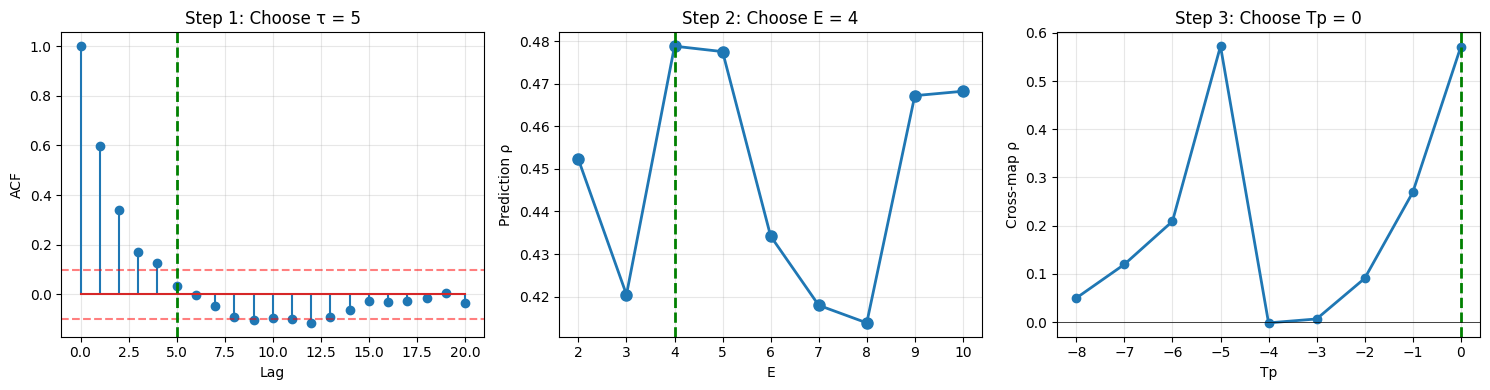


TESTING WITH SURROGATES (τ=5, E=4, Tp=0)
Computing original CCM...
Original AUC: 249.02

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:19<00:00,  5.14it/s]



Results:
  Original AUC: 249.02
  Surrogate AUC: 252.04 ± 10.41
  Effect size: -3.02
  p-value: 0.5900
  Significant: False


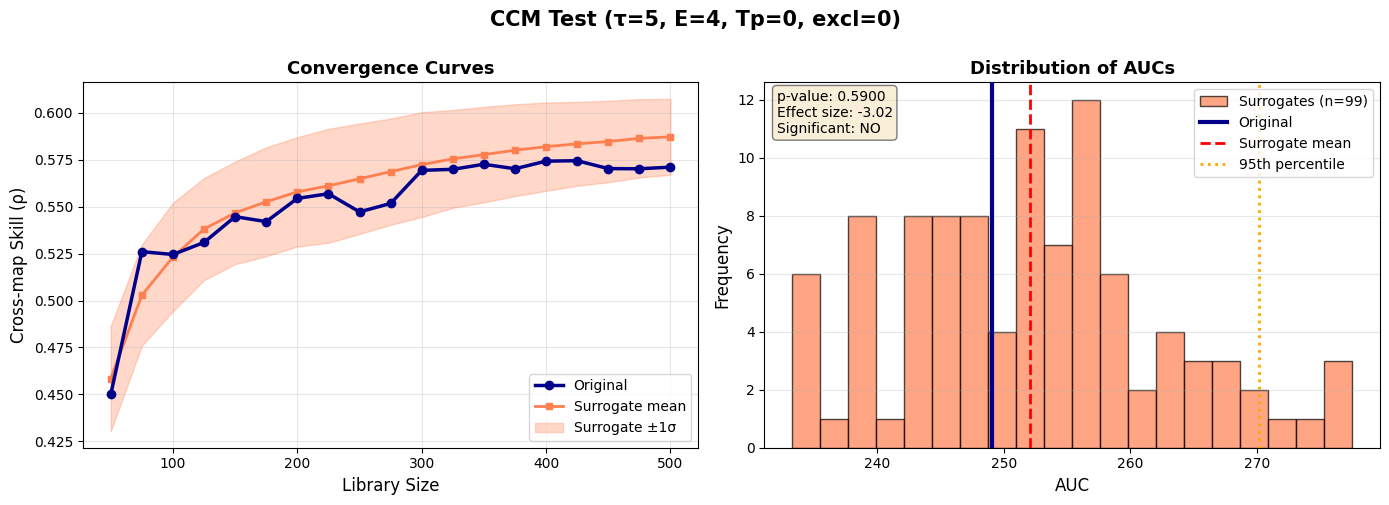

----------------------------------------------------------------------
testing Pure autocorrelated
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 8 where ACF ≈ 0.094
Step 2: Found E = 4 with ρ = 0.743
         Max ρ = 0.760, threshold = 0.731 (1σ below max)
Step 3: Found Tp = -2 with ρ = 0.029
         Max ρ = 0.042, threshold = -0.014 (1σ below max)


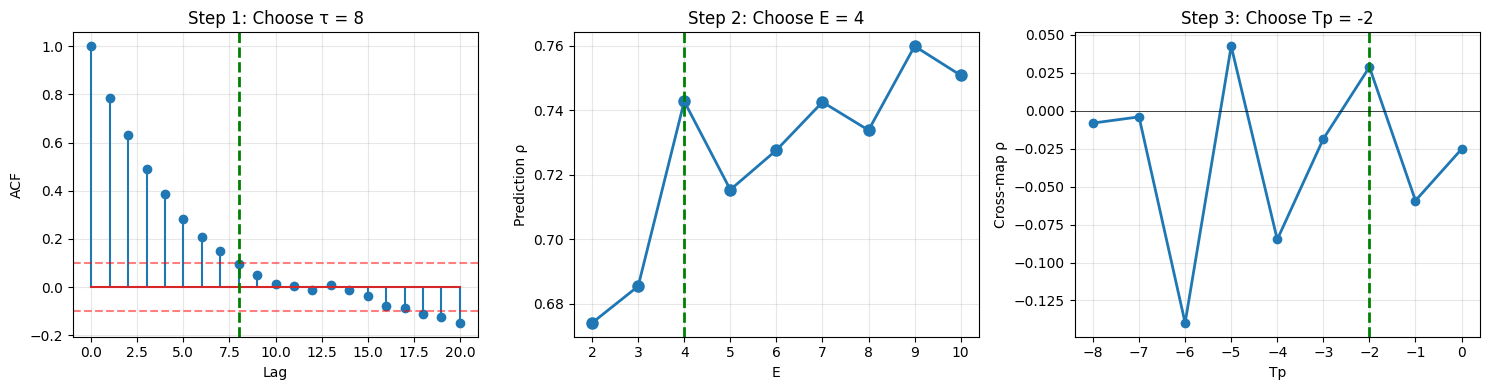


TESTING WITH SURROGATES (τ=8, E=4, Tp=-2)
Computing original CCM...
Original AUC: -9.86

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:19<00:00,  5.04it/s]



Results:
  Original AUC: -9.86
  Surrogate AUC: -9.48 ± 19.49
  Effect size: -0.39
  p-value: 0.5300
  Significant: False


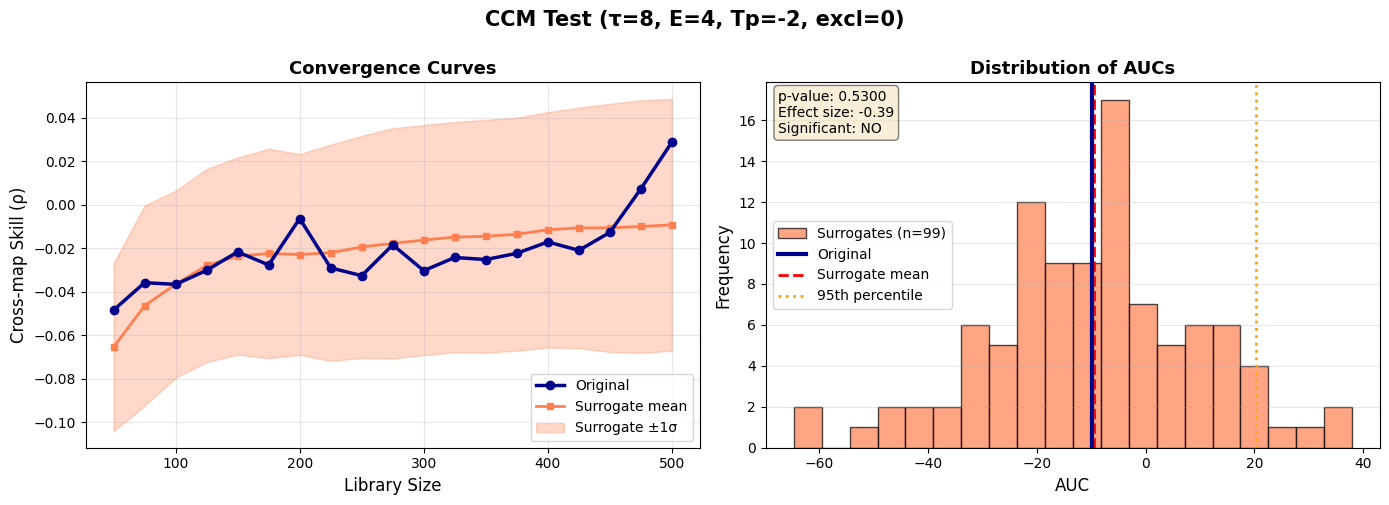

----------------------------------------------------------------------
testing Seasonal synchronous
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 6 where ACF ≈ -0.005
Step 2: Found E = 5 with ρ = 0.884
         Max ρ = 0.908, threshold = 0.882 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.896
         Max ρ = 0.903, threshold = 0.895 (1σ below max)


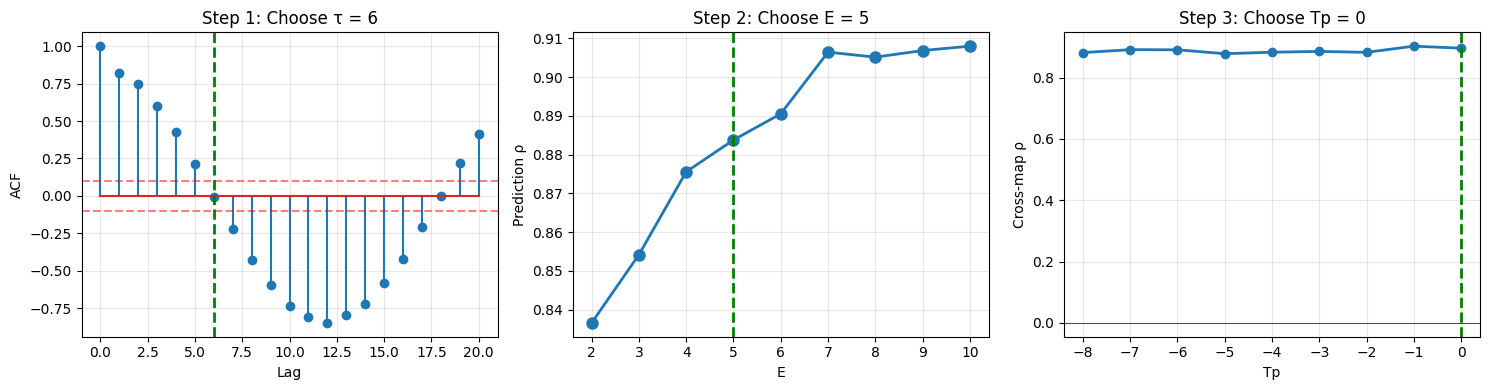


TESTING WITH SURROGATES (τ=6, E=5, Tp=0)
Computing original CCM...
Original AUC: 403.17

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:20<00:00,  4.95it/s]



Results:
  Original AUC: 403.17
  Surrogate AUC: 390.37 ± 5.84
  Effect size: 12.80
  p-value: 0.0100
  Significant: True


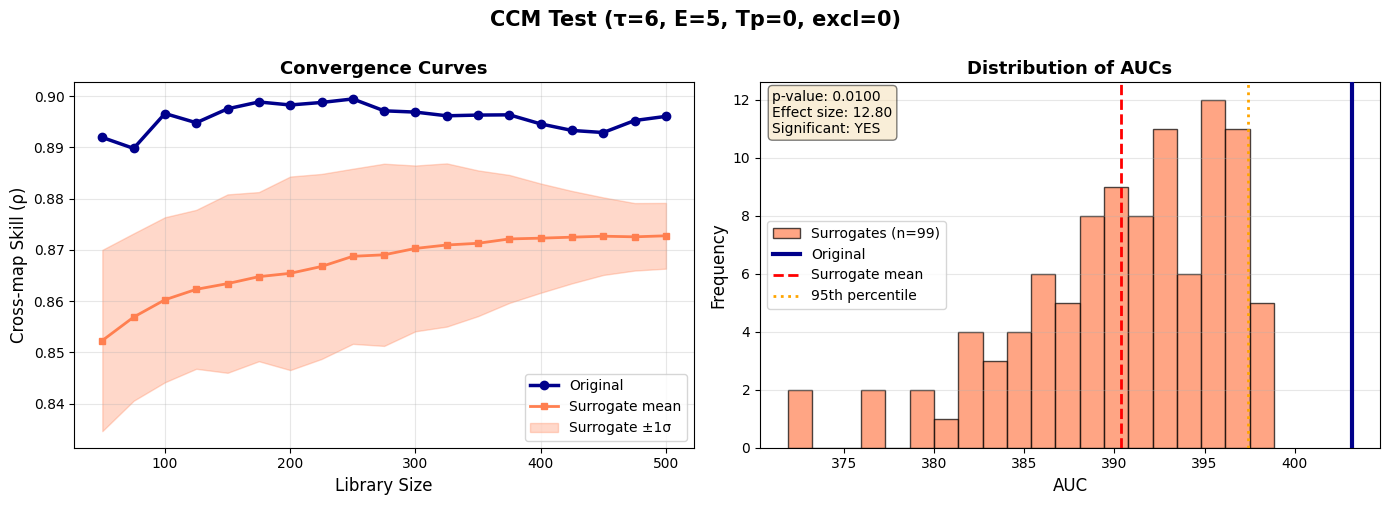

----------------------------------------------------------------------
testing Seasonal lagged
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 6 where ACF ≈ -0.001
Step 2: Found E = 4 with ρ = 0.881
         Max ρ = 0.906, threshold = 0.879 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.895
         Max ρ = 0.895, threshold = 0.888 (1σ below max)


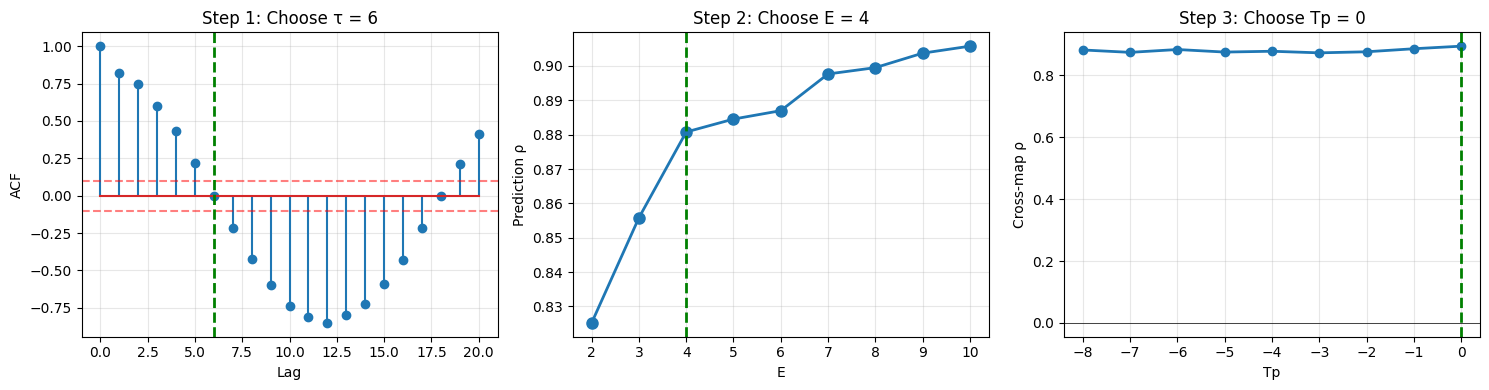


TESTING WITH SURROGATES (τ=6, E=4, Tp=0)
Computing original CCM...
Original AUC: 399.99

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:19<00:00,  5.07it/s]



Results:
  Original AUC: 399.99
  Surrogate AUC: 384.80 ± 6.27
  Effect size: 15.19
  p-value: 0.0100
  Significant: True


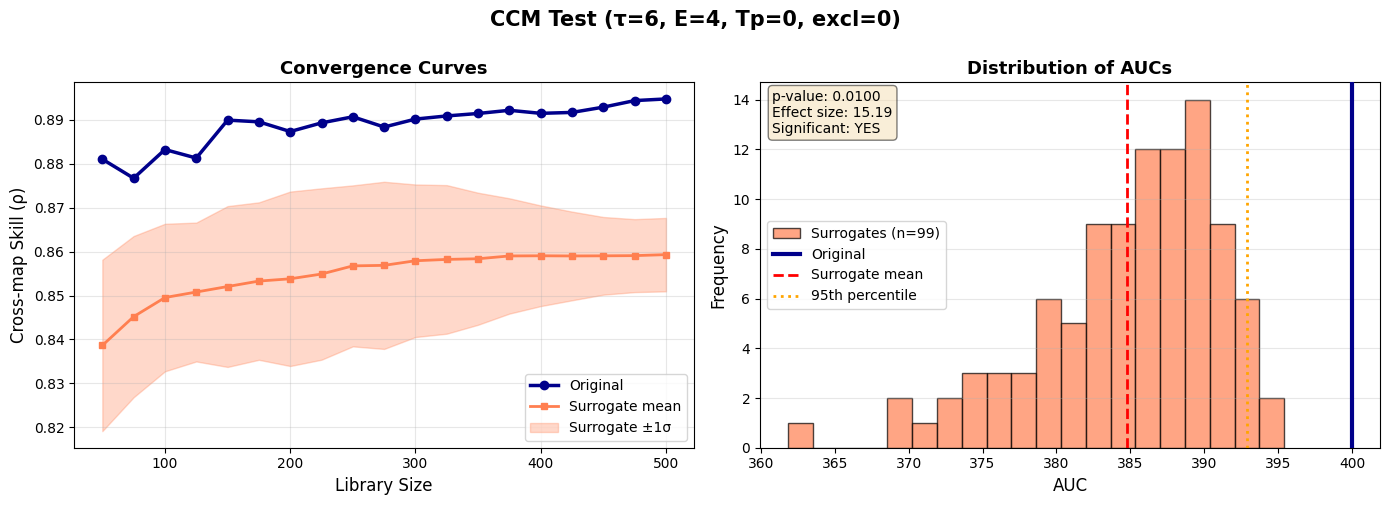

----------------------------------------------------------------------
testing Unidirectional causal
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 2 where ACF ≈ 0.046
Step 2: Found E = 2 with ρ = 0.949
         Max ρ = 0.949, threshold = 0.775 (1σ below max)
Step 3: Found Tp = -1 with ρ = 0.539
         Max ρ = 0.539, threshold = 0.335 (1σ below max)


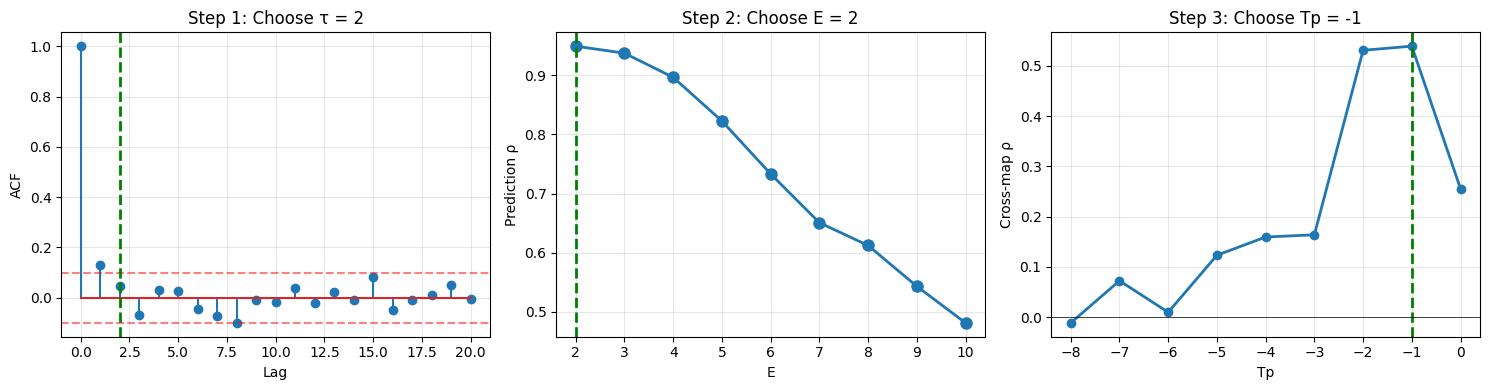


TESTING WITH SURROGATES (τ=2, E=2, Tp=-1)
Computing original CCM...
Original AUC: 215.46

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:18<00:00,  5.46it/s]



Results:
  Original AUC: 215.46
  Surrogate AUC: 43.39 ± 19.88
  Effect size: 172.07
  p-value: 0.0100
  Significant: True


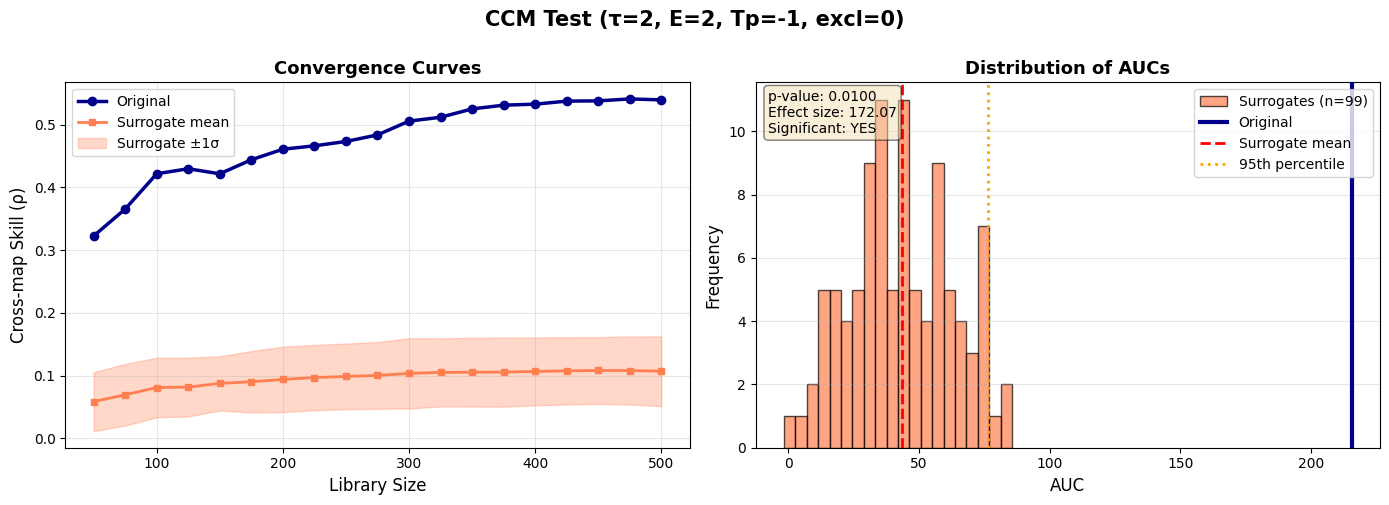

----------------------------------------------------------------------
testing Bidirectional causal
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 4 where ACF ≈ -0.071
Step 2: Found E = 2 with ρ = 0.930
         Max ρ = 0.930, threshold = 0.820 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.187
         Max ρ = 0.297, threshold = 0.142 (1σ below max)


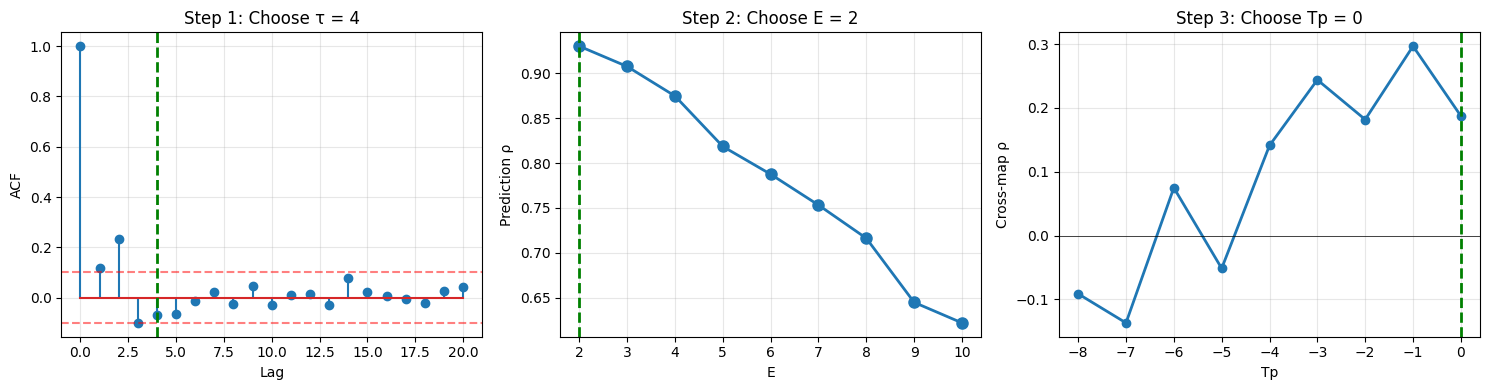


TESTING WITH SURROGATES (τ=4, E=2, Tp=0)
Computing original CCM...
Original AUC: 84.79

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:18<00:00,  5.44it/s]



Results:
  Original AUC: 84.79
  Surrogate AUC: 0.52 ± 18.69
  Effect size: 84.28
  p-value: 0.0100
  Significant: True


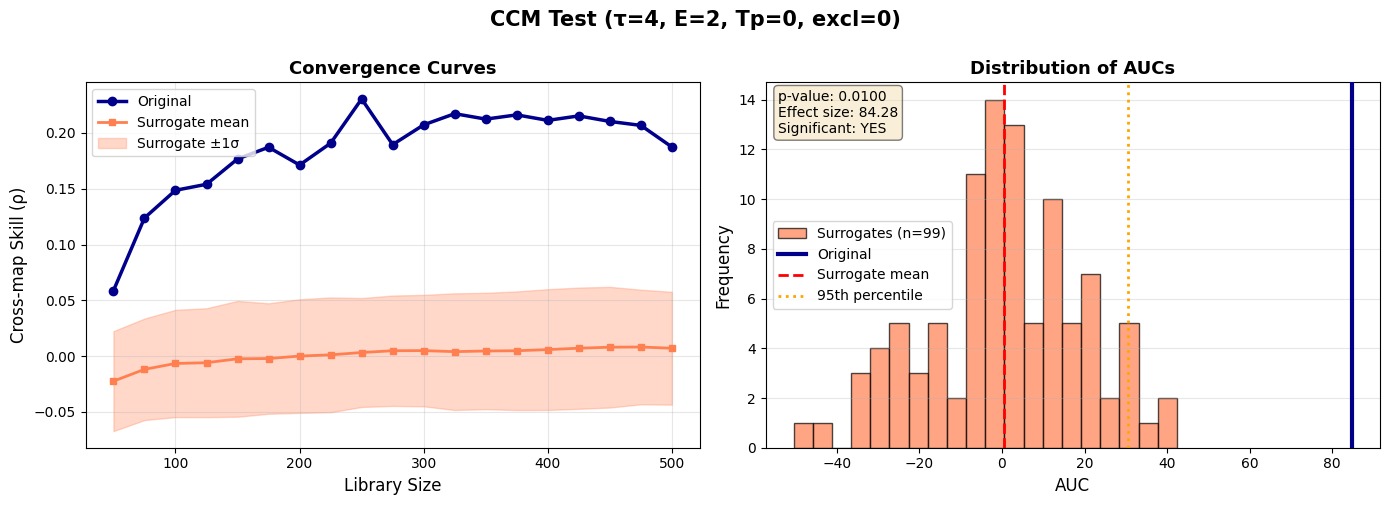

----------------------------------------------------------------------
testing Weak causal
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 1 where ACF ≈ -0.003
Step 2: Found E = 2 with ρ = 0.976
         Max ρ = 0.976, threshold = 0.840 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.185
         Max ρ = 0.336, threshold = 0.170 (1σ below max)


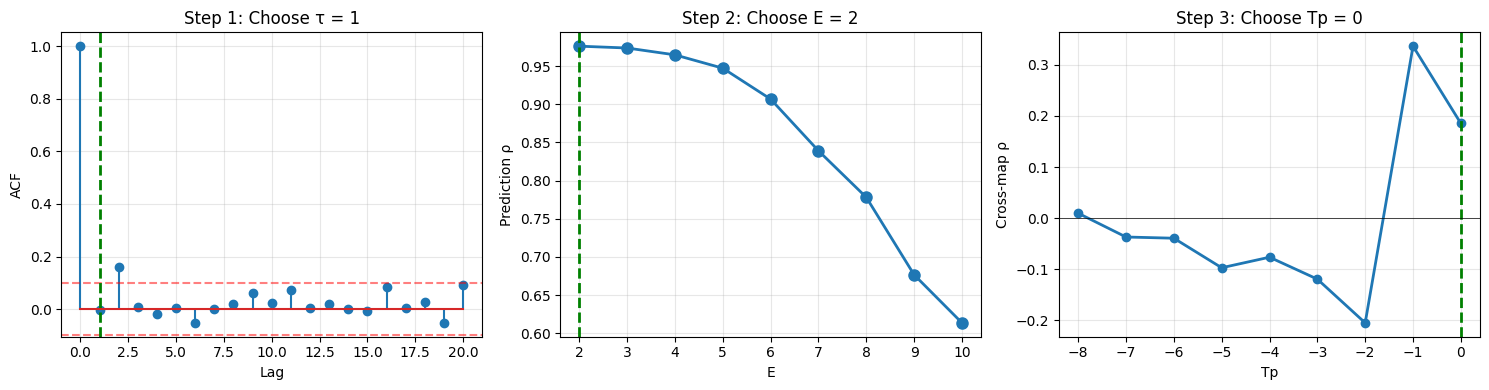


TESTING WITH SURROGATES (τ=1, E=2, Tp=0)
Computing original CCM...
Original AUC: 73.86

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:18<00:00,  5.22it/s]



Results:
  Original AUC: 73.86
  Surrogate AUC: 1.09 ± 22.72
  Effect size: 72.76
  p-value: 0.0100
  Significant: True


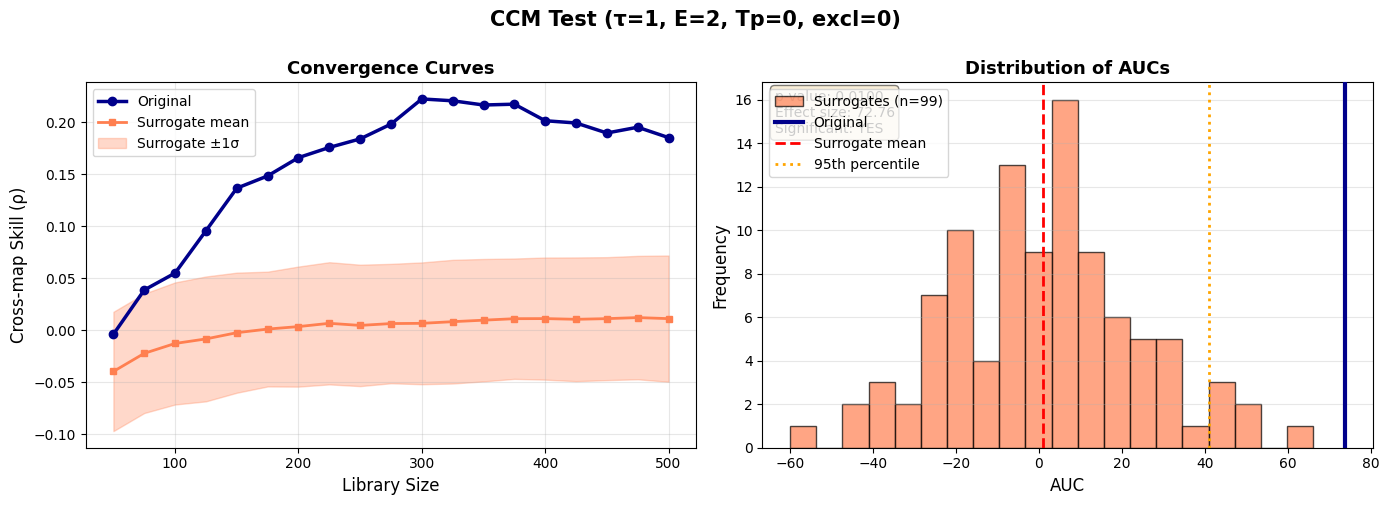

----------------------------------------------------------------------
testing Indirect causal
----------------------------------------------------------------------
STEP 1: Finding optimal τ, E, and Tp
Step 1: Found τ = 10 where ACF ≈ 0.094
Step 2: Found E = 2 with ρ = 0.966
         Max ρ = 0.966, threshold = 0.860 (1σ below max)
Step 3: Found Tp = 0 with ρ = 0.073
         Max ρ = 0.073, threshold = 0.040 (1σ below max)


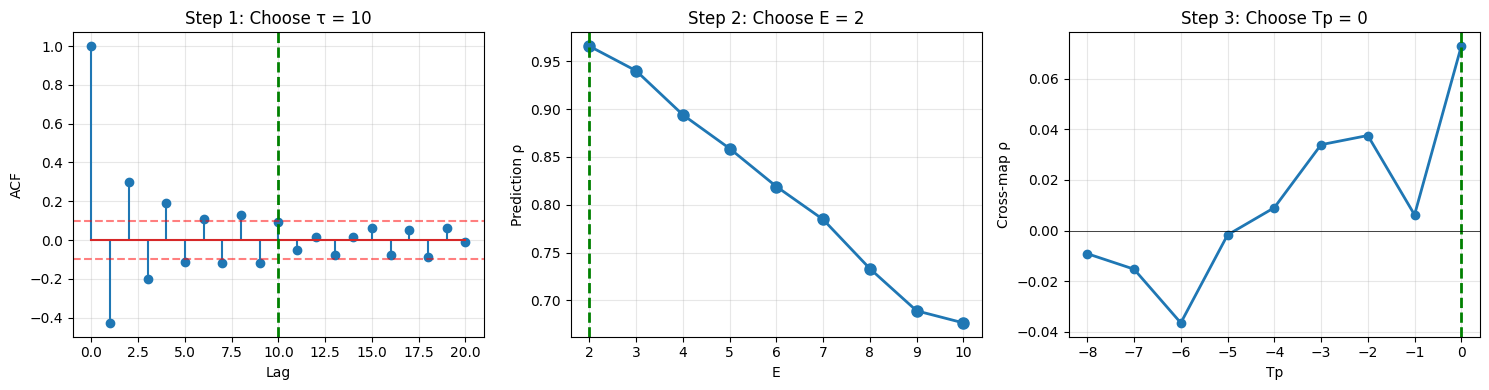


TESTING WITH SURROGATES (τ=10, E=2, Tp=0)
Computing original CCM...
Original AUC: 31.57

Computing 99 twin surrogates...


Twin surrogates: 100%|██████████████████████████| 99/99 [00:19<00:00,  5.03it/s]



Results:
  Original AUC: 31.57
  Surrogate AUC: 11.47 ± 21.64
  Effect size: 20.10
  p-value: 0.1900
  Significant: False


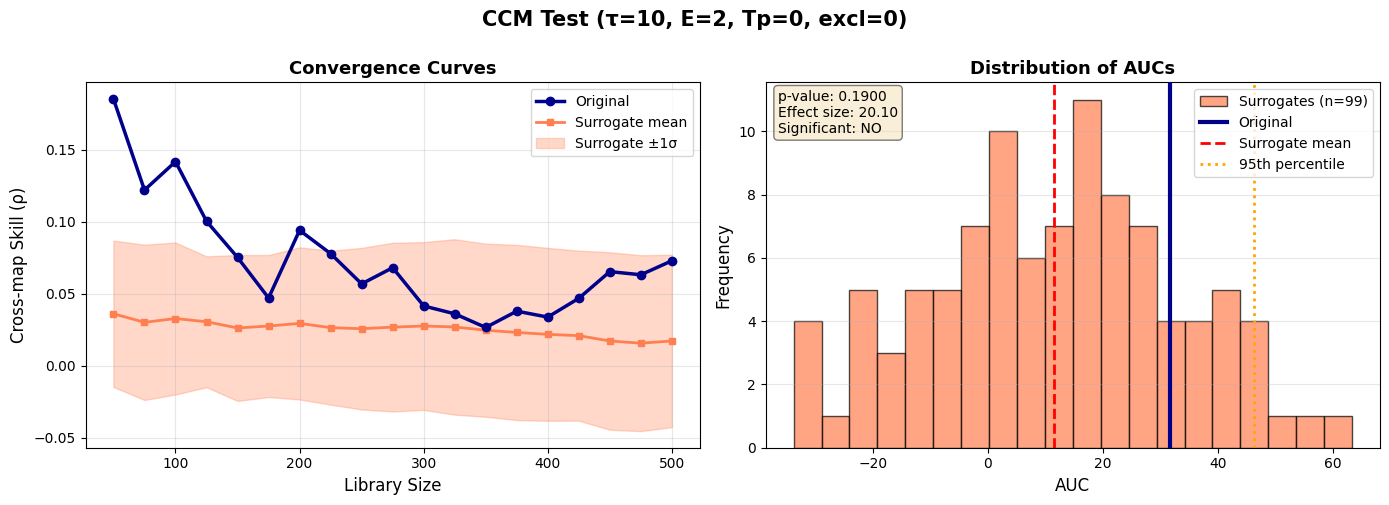

In [6]:
def find_optimal_embedding_params(Y, max_lag=20, max_E=10, n_std=1):
    """
    Step 1: Find τ where ACF(Y) ≈ 0
    Step 2: Find optimal cross-map (Y xmap X) E for that τ
    Choose smallest E that's within n_std of maximum performance.
    """

    # Step 1: Find ACF zero-crossing
    from statsmodels.tsa.stattools import acf
    acf_values = acf_nan(Y, nlags=max_lag)
    
    # Find first lag where |ACF| < 0.1
    tau_optimal = None
    for lag in range(1, len(acf_values)):
        if np.abs(acf_values[lag]) < 0.1:
            tau_optimal = lag
            break
    
    if tau_optimal is None:
        tau_optimal = max_lag
    
    print(f"Step 1: Found τ = {tau_optimal} where ACF ≈ {acf_values[tau_optimal]:.3f}")
    
    # Step 2: Find optimal E for this τ using Simplex (to unfold the attractor of Y)
    df = pd.DataFrame({'time': range(1, len(Y)+1), 'Y': Y})
    lib = f'1 {len(df)}'
    pred = lib
    
    E_results = []
    for E in range(2, max_E + 1):
        simplex = pyEDM.Simplex(
            dataFrame=df,
            lib=lib,
            pred=pred,
            columns='Y',
            target='Y',
            E=E,
            tau=-tau_optimal,
            Tp=1,
            exclusionRadius=0  # Don't use exclusion for E selection
        )
        rho = simplex[['Observations', 'Predictions']].corr().iloc[0,1]
        E_results.append({'E': E, 'rho': rho})
    
    E_df = pd.DataFrame(E_results)

    max_rho = E_df['rho'].max()
    std_rho = E_df['rho'].std()
    
    # Threshold: within n standard deviations of max
    threshold = max_rho - n_std * std_rho
    
    # Find smallest E exceeding threshold
    candidates = E_df[E_df['rho'] >= threshold].copy()
    E_optimal = candidates['E'].min()  # Just take minimum E (no abs() needed)
    
    optimal_rho = candidates[candidates['E'] == E_optimal]['rho'].iloc[0]
    
    print(f"Step 2: Found E = {E_optimal} with ρ = {optimal_rho:.3f}")
    print(f"         Max ρ = {max_rho:.3f}, threshold = {threshold:.3f} ({n_std}σ below max)")

    return tau_optimal, E_optimal, acf_values, E_df

def find_optimal_Tp(X, Y, E, tau, max_Tp=8, n_std=1):
    """
    Step 3: Find Tp that shows greatest causal effect
    Test Y xmap X at different Tp values
    Choose smallest |Tp| that's within n_std of maximum performance
    """
    
    to_xmap = pd.DataFrame({'X': X, 'Y': Y, 'time': range(1, len(X)+1)})
    
    Tp_results = []
    for Tp in range(-max_Tp, 1):
        lib = f'1 {len(to_xmap)}'
        try:
            xmap = compute_xmap_pair(
                dataFrame=to_xmap[['time', 'X', 'Y']],
                columns='Y',
                target='X',
                lib=lib,
                pred=lib,
                E=E,
                Tp=Tp,
                tau=-tau,
                exclusionRadius=0
            )
            rho = xmap[['Observations', 'Predictions']].corr().iloc[0,1]
            Tp_results.append({'Tp': Tp, 'rho': rho})
        except:
            Tp_results.append({'Tp': Tp, 'rho': np.nan})
    
    Tp_df = pd.DataFrame(Tp_results).dropna()
    
    max_rho = Tp_df['rho'].max()
    std_rho = Tp_df['rho'].std()
    
    # Threshold: within n standard deviations of max
    threshold = max_rho - n_std * std_rho
    
    # Find smallest |Tp| exceeding threshold
    candidates = Tp_df[Tp_df['rho'] >= threshold].copy()
    candidates['abs_Tp'] = candidates['Tp'].abs()
    candidates = candidates.sort_values(['abs_Tp', 'Tp'])
    
    Tp_optimal = int(candidates.iloc[0]['Tp'])
    
    print(f"Step 3: Found Tp = {Tp_optimal} with ρ = {candidates.iloc[0]['rho']:.3f}")
    print(f"         Max ρ = {max_rho:.3f}, threshold = {threshold:.3f} ({n_std}σ below max)")
    
    return Tp_optimal, Tp_df

def test_with_surrogates(X, Y, E, Tp, tau, exclusionRadius,libSizes='50 500 25', sample=50, n_surrogates=99, n_jobs=-1, seed=None):
    """
    Test CCM with twin/bivariate surrogates
    These surrogates preserve:
    - Autocorrelation of X and Y
    - Cross-correlation between X and Y (at all lags)
    But destroy:
    - Temporal order / causal dynamics
    """
    if seed is not None:
        np.random.seed(seed)
    
    print("Computing original CCM...")
    to_ccm = pd.DataFrame({'X': X, 'Y': Y, 'time': range(1, len(X)+1)})
    summary_orig, _ = compute_ccm_pair(
        to_ccm[['time', 'X', 'Y']], columns='Y', target='X', 
        libSizes=libSizes, sample=sample,
        E=E, Tp=Tp, tau=tau, exclusionRadius=exclusionRadius
    )
    
    auc_orig = compute_auc_from_summary(summary_orig)
    print(f"Original AUC: {auc_orig:.2f}")
    
    # Generate seeds
    surrogate_seeds = np.random.randint(0, 2**31, size=n_surrogates)
    
    def compute_single_twin_surrogate(seed):
        np.random.seed(seed)
        
        # Generate twin surrogates (SAME phase randomization)
        X_surr, Y_surr = twin_surrogates(X, Y)
        
        to_ccm_surr = pd.DataFrame({
            'X': X_surr, 
            'Y': Y_surr, 
            'time': range(1, len(X)+1)
        })
        
        summary_surr, _ = compute_ccm_pair(
            to_ccm_surr[['time', 'X', 'Y']], 
            columns='Y', target='X',
            libSizes=libSizes, sample=sample,
            E=E, Tp=Tp, tau=tau, exclusionRadius=exclusionRadius
        )
        
        return {
            'auc': compute_auc_from_summary(summary_surr),
            'summary': summary_surr
        }
    
    print(f"\nComputing {n_surrogates} twin surrogates...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_single_twin_surrogate)(seed)
        for seed in tqdm(surrogate_seeds, desc="Twin surrogates")
    )
    
    auc_surrogates = [r['auc'] for r in results]
    surrogate_summaries = [r['summary'] for r in results]
    
    p_value = (sum(np.array(auc_surrogates) >= auc_orig) + 1) / (n_surrogates + 1)
    
    # Compute mean and std of surrogate convergence curves
    lib_sizes = summary_orig['LibSize'].values
    surrogate_rhos = np.array([s['rho_mean'].values for s in surrogate_summaries])
    surrogate_mean = np.mean(surrogate_rhos, axis=0)
    surrogate_std = np.std(surrogate_rhos, axis=0)
    
    print(f"\nResults:")
    print(f"  Original AUC: {auc_orig:.2f}")
    print(f"  Surrogate AUC: {np.mean(auc_surrogates):.2f} ± {np.std(auc_surrogates):.2f}")
    print(f"  Effect size: {auc_orig - np.mean(auc_surrogates):.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant: {p_value <= 0.01}")
    
    return {
        'auc_original': auc_orig,
        'auc_surrogates': auc_surrogates,
        'p_value': p_value,
        'is_significant': p_value <= 0.01,
        'summary_original': summary_orig,
        'lib_sizes': lib_sizes,
        'surrogate_mean': surrogate_mean,
        'surrogate_std': surrogate_std,
        'effect_size': auc_orig - np.mean(auc_surrogates)
    }

def compute_auc_from_summary(summary):
    """Compute AUC from a CCM summary dataframe"""
    valid_data = summary.dropna(subset=['rho_mean'])
    if len(valid_data) == 0:
        return np.nan
    lib_sizes = valid_data['LibSize'].values
    rho_values = valid_data['rho_mean'].values
    auc = np.trapezoid(rho_values, lib_sizes)
    return auc

def plot_significance_test(result, title="CCM Significance Test"):
    """
    Visualize the significance test results
    
    Creates a figure with:
    - Left: Convergence curves (original vs surrogate mean ± std)
    - Right: Histogram of surrogate AUCs with original AUC marked
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: Convergence curves
    ax = axes[0]
    lib_sizes = result['lib_sizes']
    orig_rho = result['summary_original']['rho_mean'].values
    surr_mean = result['surrogate_mean']
    surr_std = result['surrogate_std']
    
    # Handle NaNs - create mask for valid data points
    valid_mask = ~(np.isnan(orig_rho) | np.isnan(surr_mean) | np.isnan(surr_std))
    
    if np.any(valid_mask):
        # Plot original
        ax.plot(lib_sizes[valid_mask], orig_rho[valid_mask], 'o-', color='darkblue', 
                linewidth=2.5, markersize=6, label='Original', zorder=3)
        
        # Plot surrogate mean
        ax.plot(lib_sizes[valid_mask], surr_mean[valid_mask], 's-', color='coral', 
                linewidth=2, markersize=5, label='Surrogate mean', zorder=2)
        
        # Plot surrogate ±1 std
        ax.fill_between(lib_sizes[valid_mask], 
                         surr_mean[valid_mask] - surr_std[valid_mask], 
                         surr_mean[valid_mask] + surr_std[valid_mask],
                         alpha=0.3, color='coral', label='Surrogate ±1σ', zorder=1)
    else:
        ax.text(0.5, 0.5, 'No valid data points', 
                transform=ax.transAxes, ha='center', va='center',
                fontsize=12, color='red')
    
    ax.set_xlabel('Library Size', fontsize=12)
    ax.set_ylabel('Cross-map Skill (ρ)', fontsize=12)
    ax.set_title('Convergence Curves', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Right panel: Histogram of surrogate AUCs
    ax = axes[1]
    auc_surrogates = np.array(result['auc_surrogates'])  # Convert to numpy array
    auc_orig = result['auc_original']
    
    # Filter out NaN AUCs from surrogates
    valid_surrogates = auc_surrogates[~np.isnan(auc_surrogates)]
    
    if len(valid_surrogates) > 0:
        # Histogram
        ax.hist(valid_surrogates, bins=20, alpha=0.7, color='coral', 
                edgecolor='black', label=f'Surrogates (n={len(valid_surrogates)})')
        
        # Mark original AUC (if not NaN)
        if not np.isnan(auc_orig):
            ymin, ymax = ax.get_ylim()
            ax.axvline(auc_orig, color='darkblue', linewidth=3, 
                       label=f'Original', zorder=3)
        
        # Surrogate mean
        ax.axvline(np.mean(valid_surrogates), color='red', linewidth=2, 
                   linestyle='--', label='Surrogate mean', zorder=2)
        
        # Mark 95th percentile
        percentile_95 = np.percentile(valid_surrogates, 95)
        ax.axvline(percentile_95, color='orange', linewidth=2, 
                   linestyle=':', label='95th percentile', zorder=2)
    else:
        ax.text(0.5, 0.5, 'No valid surrogate AUCs', 
                transform=ax.transAxes, ha='center', va='center',
                fontsize=12, color='red')
    
    ax.set_xlabel('AUC', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of AUCs', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    p_val = result['p_value']
    effect = result['effect_size']
    
    # Format with proper conditional logic outside f-string
    p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
    effect_str = f"{effect:.2f}" if not np.isnan(effect) else "N/A"
    
    stats_text = f"p-value: {p_val_str}\n"
    stats_text += f"Effect size: {effect_str}\n"
    stats_text += f"Significant: {'YES' if result['is_significant'] else 'NO'}"
    
    if len(valid_surrogates) < len(auc_surrogates):
        n_failed = len(auc_surrogates) - len(valid_surrogates)
        stats_text += f"\n({n_failed} surrogates failed)"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    fig.suptitle(title, fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    return fig

# Full workflow
def test_with_proper_workflow(X, Y, n_surrogates=99, exclusionRadius=0):
    """
    Test CCM with proper parameter selection workflow
    """
    print("="*70)
    print("STEP 1: Finding optimal τ, E, and Tp")
    print("="*70)
    
    # Find optimal tau, E, and Tp
    tau_opt, E_opt, acf_vals, E_results = find_optimal_embedding_params(Y)
    Tp_opt, Tp_results = find_optimal_Tp(X, Y, E_opt, tau_opt)
    
    # Visualize parameter selection
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # ACF plot
    axes[0].stem(range(len(acf_vals)), acf_vals)
    axes[0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
    axes[0].axhline(y=-0.1, color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(x=tau_opt, color='green', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('ACF')
    axes[0].set_title(f'Step 1: Choose τ = {tau_opt}')
    axes[0].grid(True, alpha=0.3)
    
    # E optimization plot
    axes[1].plot(E_results['E'], E_results['rho'], 'o-', linewidth=2, markersize=8)
    axes[1].axvline(x=E_opt, color='green', linestyle='--', linewidth=2)
    axes[1].set_xlabel('E')
    axes[1].set_ylabel('Prediction ρ')
    axes[1].set_title(f'Step 2: Choose E = {E_opt}')
    axes[1].grid(True, alpha=0.3)
    
    # Tp optimization plot
    axes[2].plot(Tp_results['Tp'], Tp_results['rho'], 'o-', linewidth=2, markersize=6)
    axes[2].axvline(x=Tp_opt, color='green', linestyle='--', linewidth=2)
    axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[2].set_xlabel('Tp')
    axes[2].set_ylabel('Cross-map ρ')
    axes[2].set_title(f'Step 3: Choose Tp = {Tp_opt}')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Now test with surrogates
    print("\n" + "="*70)
    print(f"TESTING WITH SURROGATES (τ={tau_opt}, E={E_opt}, Tp={Tp_opt})")
    print("="*70)
    
    result = test_with_surrogates(
        X, Y, 
        E=E_opt, 
        Tp=Tp_opt, 
        tau=-tau_opt, 
        exclusionRadius=exclusionRadius,
        libSizes='50 500 25', 
        sample=50, 
        n_surrogates=n_surrogates,
        n_jobs=-1,
        seed=42
    )
    
    fig = plot_significance_test(result, 
                                  title=f"CCM Test (τ={tau_opt}, E={E_opt}, Tp={Tp_opt}, excl={exclusionRadius})")
    plt.show()
    
    return result, tau_opt, E_opt, Tp_opt


for case in test_cases:
    name = case[0]
    print('-'*70)
    print(f'testing {name}')
    print('-'*70)
    X_test = case[1]
    Y_test = case[2]
    result, tau_opt, E_opt, Tp_opt = test_with_proper_workflow(X_test, Y_test)